<a href="https://colab.research.google.com/github/NicoleLund/flight_delay_prediction/blob/model_prep_210819/data_manipulation_modeling/investigate_models/a_decision_tree_all_y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# a_decision_tree_all_y
----

Written in Google Colab

By Nicole Lund 

This workbook builds a decision tree model for 2017 flight performance.

In [1]:
# Import Dependencies

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Data manipulation
import numpy as np
import pandas as pd
from statistics import mean
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

# Parameter Selection
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Model Development
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Model Metrics
from sklearn.metrics import classification_report

# Save/load files
from tensorflow.keras.models import load_model
import joblib

# # Ignore deprecation warnings
# import warnings
# warnings.simplefilter('ignore', FutureWarning)

In [2]:
# Set the seed value for the notebook, so the results are reproducible
from numpy.random import seed
seed(1)

# Read in the csv model files

In [3]:
# Read the CSV files from AWS to Pandas Dataframe
X_train = pd.read_csv("https://flight-delay-prediction.s3.us-west-1.amazonaws.com/2017_TUS_X_train.csv")
X_test = pd.read_csv("https://flight-delay-prediction.s3.us-west-1.amazonaws.com/2017_TUS_X_test.csv")
y_train = pd.read_csv("https://flight-delay-prediction.s3.us-west-1.amazonaws.com/2017_TUS_y_train.csv")
y_test = pd.read_csv("https://flight-delay-prediction.s3.us-west-1.amazonaws.com/2017_TUS_y_test.csv")

In [47]:
X_train.columns

Index(['OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'DISTANCE', 'DL',
       'OO', 'UA', 'WN', 'AA', 'EV', 'AS', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'ATL', 'DEN', 'DFW',
       'HOU', 'IAH', 'JFK', 'LAS', 'LAX', 'MDW', 'MSP', 'OAK', 'ORD', 'PDX',
       'PHX', 'SAN', 'SEA', 'SFO', 'SJC', 'SLC'],
      dtype='object')

In [48]:
X_train = X_train[['OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'DISTANCE', 'DL',
       'OO', 'UA', 'WN', 'AA', 'EV', 'AS', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday']]

In [ ]:
X_test = X_test[['OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'DISTANCE', 'DL',
       'OO', 'UA', 'WN', 'AA', 'EV', 'AS', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday']]

In [49]:
X_train.head(3)

,OP_CARRIER_FL_NUM,CRS_DEP_TIME,CRS_ARR_TIME,DISTANCE,DL,OO,UA,WN,AA,EV,AS,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,5538,1120,1647,1437,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5538,1219,1650,1437,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2068,1625,2040,1440,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
y_train.head(3)

,CANCELLED,DIVERTED,DELAY
0,0,0,0
1,0,0,0
2,0,0,0


## Decision Tree Classifier Method

In [6]:
# Create and score a decision tree classifier
model = tree.DecisionTreeClassifier()
model = model.fit(X_train, y_train)

In [7]:
# Sort the features by their importance
tree_feature_sort = sorted(zip(X_train.columns,model.feature_importances_),key=itemgetter(1), reverse=True)
# tree_feature_sort

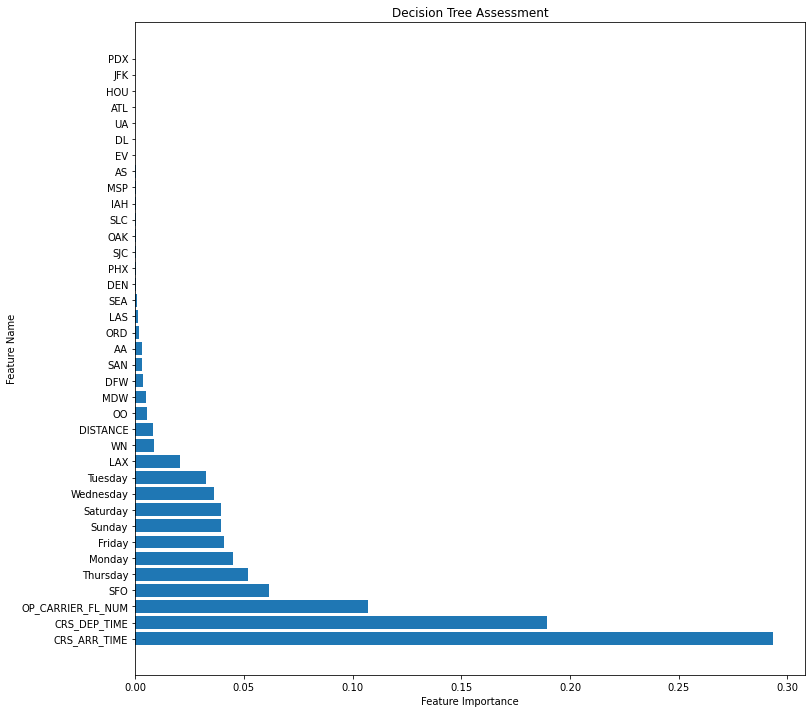

In [8]:
# Plot Decision Tree Feature Importance
fig = plt.figure(figsize=[12,12])
plt.barh(*zip(* (tree_feature_sort)))
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Decision Tree Assessment')
plt.show()

# Score Model

In [9]:
print('Decision Tree Score:')
print(model.score(X_test, y_test))

Decision Tree Score:
0.8688879273041973


# Make **Predictions**

In [10]:
predictions = model.predict(X_test)

In [32]:
results_cancelled = pd.DataFrame({ \
            "CANCELLED": y_test.CANCELLED,"CANCELLED_PREDICT": predictions[:,0]})
results_diverted = pd.DataFrame({ \
            "DIVERTED": y_test.DIVERTED,"DIVERTED_PREDICT": predictions[:,1]})
results_delayed = pd.DataFrame({ \
            "DELAY": y_test.DELAY, "DELAY_PREDICT": predictions[:,2]})

In [50]:
cancel_summary = results_cancelled.apply(pd.value_counts)
cancel_summary

,CANCELLED,CANCELLED_PREDICT
0,4590,4621
1,32,1


In [51]:
print(classification_report(y_test.CANCELLED, predictions[:,0]))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4590
           1       0.00      0.00      0.00        32

    accuracy                           0.99      4622
   macro avg       0.50      0.50      0.50      4622
weighted avg       0.99      0.99      0.99      4622



In [52]:
diverted_summary = results_diverted.apply(pd.value_counts)
diverted_summary

,DIVERTED,DIVERTED_PREDICT
0,4613,4621
1,9,1


In [53]:
print(classification_report(y_test.DIVERTED, predictions[:,1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4613
           1       0.00      0.00      0.00         9

    accuracy                           1.00      4622
   macro avg       0.50      0.50      0.50      4622
weighted avg       1.00      1.00      1.00      4622



In [54]:
delay_summary = results_delayed.apply(pd.value_counts)
delay_summary

,DELAY,DELAY_PREDICT
0,4087,4448
1,535,174


In [55]:
print(classification_report(y_test.DELAY, predictions[:,2]))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      4087
           1       0.30      0.10      0.15       535

    accuracy                           0.87      4622
   macro avg       0.60      0.53      0.54      4622
weighted avg       0.82      0.87      0.84      4622

